In [1]:
import numpy as np
import pyopencl as cl
from PIL import Image

In [2]:
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

In [3]:
shape = (800, 600)
shape_np = (shape[1], shape[0])
shape_np_col = (shape[1], shape[0], 3)

In [4]:
a_np = (255 * np.random.rand(*shape_np_col)).astype(np.uint8)
b_np = (255 * np.random.rand(*shape_np_col)).astype(np.uint8)

In [5]:
mf = cl.mem_flags
a_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=a_np)
b_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=b_np)

In [6]:
prg = cl.Program(
    ctx,
    """
__kernel void sum(
    __global const uchar *a_g, __global const uchar *b_g, __global uchar *res_g)
{
  uint2 gi = (uint2)(get_global_id(0), get_global_id(1));
  uint2 gs = (uint2)(get_global_size(0), get_global_size(1));
  uint p = (gi.x + gs.x*gi.y);
  uchar3 col = (uchar3)(gi.x + gi.y, gi.x/2 + gi.y, gi.x + gi.y/3);
  vstore3(col, p, res_g);
}
""",
).build()


In [7]:
res_g = cl.Buffer(ctx, mf.WRITE_ONLY, a_np.nbytes)
prg.sum(queue, shape, None, a_g, b_g, res_g)

In [8]:
res_np = np.empty_like(a_np)
cl.enqueue_copy(queue, res_np, res_g)

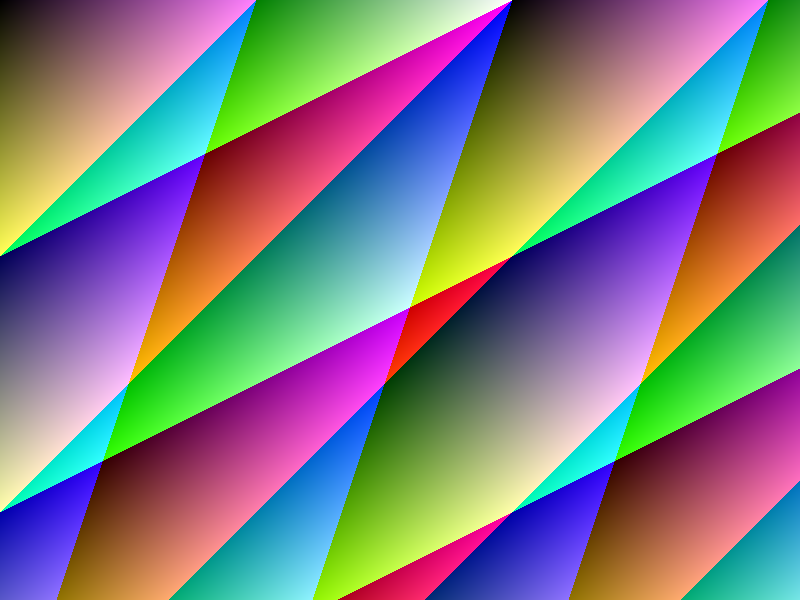

In [9]:
Image.fromarray(res_np)